# Forest Cover Type Prediction
[Kaggle](https://www.kaggle.com/c/forest-cover-type-prediction)

You are asked to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. 

In [1]:
import pandas as pd
import numpy as np

import brewer2mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.grid_search import GridSearchCV

In [3]:
train = pd.read_csv('train.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

**Elevation** - Elevation in meters  
**Aspect** - Aspect in degrees azimuth  
**Slope** - Slope in degrees  
**Horizontal_Distance_To_Hydrology** - Horz Dist to nearest surface water features    
**Vertical_Distance_To_Hydrology** - Vert Dist to nearest surface water features  
**Horizontal_Distance_To_Roadways** - Horz Dist to nearest roadway  
**Hillshade_9am** (0 to 255 index) - Hillshade index at 9am, summer solstice  
**Hillshade_Noon** (0 to 255 index) - Hillshade index at noon, summer solstice   
**Hillshade_3pm** (0 to 255 index) - Hillshade index at 3pm, summer solstice  
**Horizontal_Distance_To_Fire_Points** - Horz Dist to nearest wildfire ignition points  
**Wilderness_Area** (4 binary columns, 0 = absence or 1 = presence) - Wilderness area   designation  
**Soil_Type** (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation  
**Cover_Type** (7 types, integers 1 to 7) - Forest Cover Type designation  

The wilderness areas are:

1. Rawah Wilderness Area  
2. Neota Wilderness Area
3. Comanche Peak Wilderness Area
4. Cache la Poudre Wilderness Area

The soil types are:

1. Cathedral family - Rock outcrop complex, extremely stony.
2. Vanet - Ratake families complex, very stony.
3. Haploborolis - Rock outcrop complex, rubbly.
4. Ratake family - Rock outcrop complex, rubbly.
5. Vanet family - Rock outcrop complex complex, rubbly.
6. Vanet - Wetmore families - Rock outcrop complex, stony.
7. Gothic family.
8. Supervisor - Limber families complex.
9. Troutville family, very stony.
10. Bullwark - Catamount families - Rock outcrop complex, rubbly.
11. Bullwark - Catamount families - Rock land complex, rubbly.
12. Legault family - Rock land complex, stony.
13. Catamount family - Rock land - Bullwark family complex, rubbly.
14. Pachic Argiborolis - Aquolis complex.
15. unspecified in the USFS Soil and ELU Survey.
16. Cryaquolis - Cryoborolis complex.
17. Gateview family - Cryaquolis complex.
18. Rogert family, very stony.
19. Typic Cryaquolis - Borohemists complex.
20. Typic Cryaquepts - Typic Cryaquolls complex.
21. Typic Cryaquolls - Leighcan family, till substratum complex.
22. Leighcan family, till substratum, extremely bouldery.
23. Leighcan family, till substratum - Typic Cryaquolls complex.
24. Leighcan family, extremely stony.
25. Leighcan family, warm, extremely stony.
26. Granile - Catamount families complex, very stony.
27. Leighcan family, warm - Rock outcrop complex, extremely stony.
28. Leighcan family - Rock outcrop complex, extremely stony.
29. Como - Legault families complex, extremely stony.
30. Como family - Rock land - Legault family complex, extremely stony.
31. Leighcan - Catamount families complex, extremely stony.
32. Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
33. Leighcan - Catamount families - Rock outcrop complex, extremely stony.
34. Cryorthents - Rock land complex, extremely stony.
35. Cryumbrepts - Rock outcrop - Cryaquepts complex.
36. Bross family - Rock land - Cryumbrepts complex, extremely stony.
37. Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
38. Leighcan - Moran families - Cryaquolls complex, extremely stony.
39. Moran family - Cryorthents - Leighcan family complex, extremely stony.
40. Moran family - Cryorthents - Rock land complex, extremely stony.

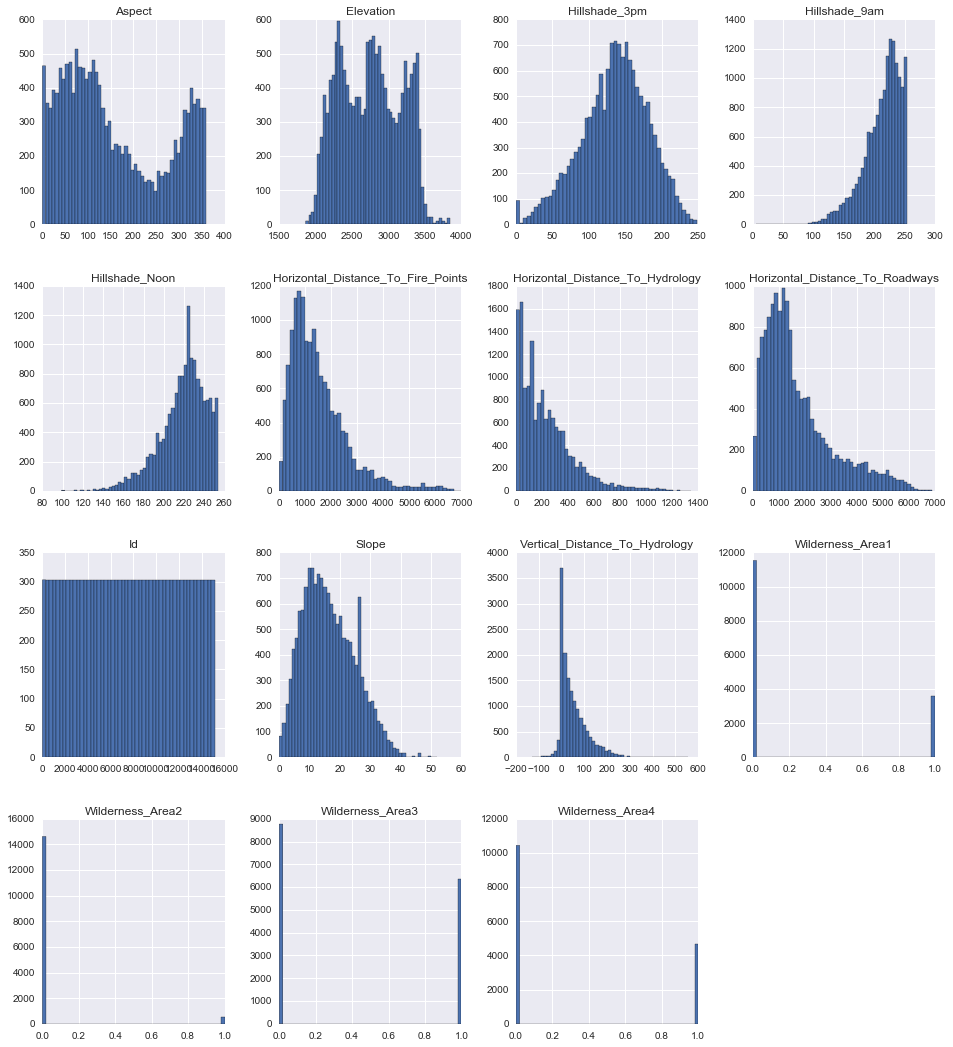

In [5]:
train.ix[:,:15].hist(figsize=(16,18),bins=50)
plt.show()

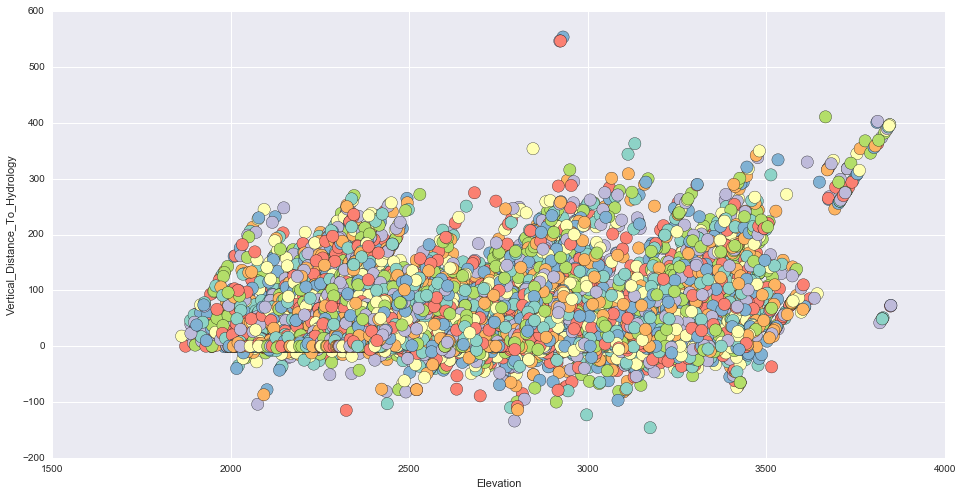

In [6]:
def plotc(c1,c2):
    colors = brewer2mpl.get_map('Set3', 'qualitative', 7).mpl_colors
    
    fig = plt.figure(figsize=(16,8))
    #colors = np.array(list(train.Cover_Type.values))
    
    plt.scatter(c1, c2,s=150, c=colors)
    plt.xlabel(c1.name)
    plt.ylabel(c2.name)
    
plotc(train.Elevation, train.Vertical_Distance_To_Hydrology)

In [7]:
def select_features(data):
    return [feat for feat in data.columns if feat not in ['Id', 'Cover_Type']]

def get_X_y(data, cols=None):
    if not cols:
        cols = select_features(data)
        
    X = data[cols].values
    y = data['Cover_Type'].values
    
    return X,y

def draw_importance_features(data, model=RandomForestClassifier(), limit=15):
    X,y = get_X_y(data)
    cols = select_features(data)
    
    model.fit(X, y)
    feats = pd.DataFrame(model.feature_importances_, index=data[cols].columns)
    return feats.sort_values(by=[0], ascending=False) [:limit].plot(kind='bar', figsize=(10, 6))

In [8]:
X,y = get_X_y(train)

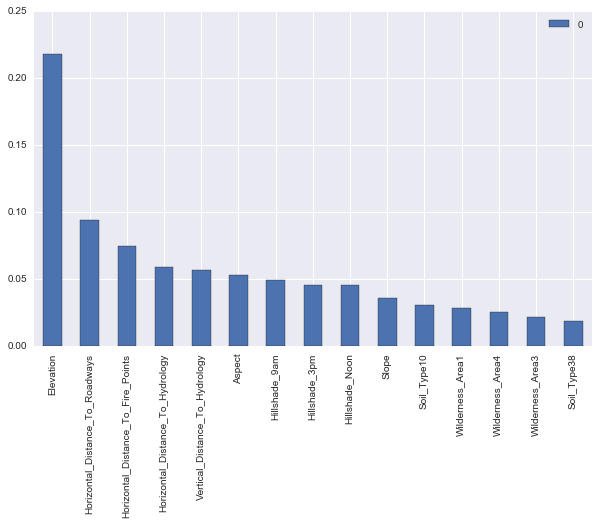

In [9]:
draw_importance_features(train)

In [10]:
def models():
    yield ExtraTreesClassifier()
    #yield RandomForestClassifier() 
    #yield KNeighborsClassifier() 
    #yield DecisionTreeClassifier() 
    #yield AdaBoostClassifier() 
    #yield BaggingClassifier() 
    #yield GradientBoostingClassifier() 

for model in models():
    n = len(X[0])
    parameters = {'n_estimators': [300], 'max_depth': [75], 'min_samples_leaf': [1]}
    grid = GridSearchCV(model, parameters, cv=3, scoring='accuracy')
    grid.fit(X, y)

    print(model.__class__, grid.best_score_, grid.best_params_)

(<class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 0.77850529100529098, {'n_estimators': 300, 'max_depth': 75, 'min_samples_leaf': 1})


In [11]:
## Feature

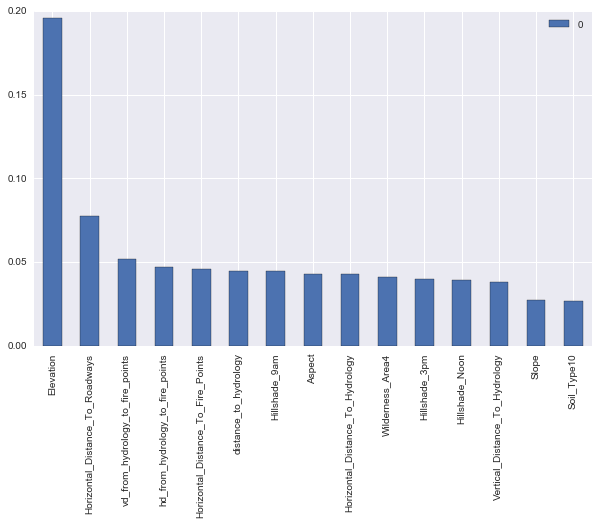

In [21]:
def distance(row, field_one, field_two):
    return np.sqrt( np.power(row[field_one], 2) + np.power(row[field_two], 2) )
    
    
def etl(data):
    data['is_positive_vertical_distance_to_hydrology'] = data['Vertical_Distance_To_Hydrology'] > 0
    data['distance_to_hydrology'] = data.apply(lambda x: distance(x, 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'), axis=1)

    data['hd_from_hydrology_to_fire_points'] = data.apply(lambda x: distance(x, 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Fire_Points'), axis=1)
    #data['hd_from_hydrology_to_road_ways'] = ...
    #data['hd_from_fire_points_to_road_ways'] = ...
    
    data['vd_from_hydrology_to_fire_points'] = data.apply(lambda x: distance(x, 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Fire_Points'), axis=1)
    #data['vd_from_hydrology_to_road_ways'] = ...
    
    #data['evdh'] = data['Elevation'] - data['Vertical_Distance_To_Hydrology']
    #data['ehdh'] = data['Elevation'] - data['Horizontal_Distance_To_Hydrology']
    

etl(train)
draw_importance_features(train)